# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget

import tensorflow as tf
import numpy as np
import os
from utils import *


Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname
abs
fs,x = wav2audio_segment(filename,10,100)
S = audio2spectral(x,orig_fs=fs,resample_fs=22050,representation='CQT',units='db',nfft_size= 2**10,
         frame_size=64, n_bins = 64,normalization_axis=None)

/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


Dimensions: data length, freq bins, time bins
120 64 64


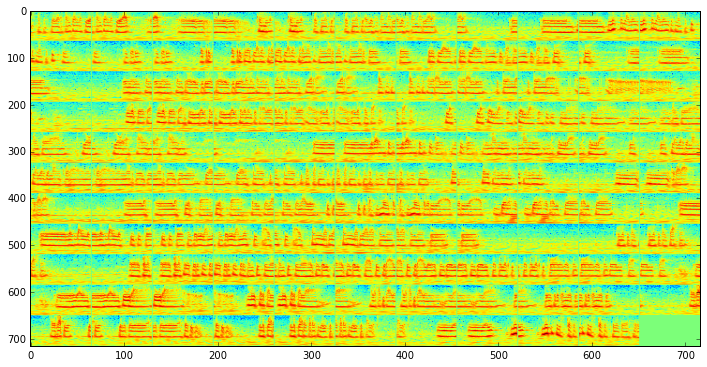

In [3]:
print("Dimensions: data length, freq bins, time bins")
batch_length, freq_bins,time_bins = S.shape
print(batch_length, freq_bins,time_bins)

# imshow(S[21],aspect='auto',origin='bottom');
figure(figsize=(12,6))
imshow(montage(S),aspect='auto');

In [4]:
data = Data( S.reshape((batch_length,freq_bins*time_bins)) )

In [58]:
mean_img = data.data.mean(0)

batch_size = 64
n_epochs = 200
learning_rate = 0.001
n_filters=[16,16,16]
n_features =  int(data.data.shape[1])
input_shape = [None, n_features]
filter_sizes = [4,4,4]
stri = [1, 3, 3, 1]

In [59]:
input_shape

[None, 4096]

In [60]:
# %%
tf.reset_default_graph()
# input to the network
X = tf.placeholder( tf.float32, input_shape, name='x')

X_tensor = tf.reshape(X, [-1, freq_bins, time_bins, 1])

current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []
l = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

z = current_input
# %%
# store the latent representation
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
l.append(current_input)

# %%
# now have the reconstruction through the network
Y = current_input
Y = tf.reshape(Y, [-1, n_features])
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

ae = {'X': X, 'z': z, 'Y': Y, 'cost': cost}

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


[16, 16, 1] [4, 4, 4] [[None, 8, 8, 16], [None, 22, 22, 16], [None, 64, 64, 1]]


[16, 16, 1] [4, 4, 4] [[None, 8, 8, 16], [None, 22, 22, 16], [None, 64, 64, 1]]


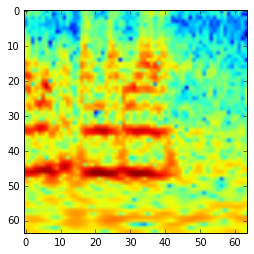

In [61]:
print(n_filters, filter_sizes, shapes)
imshow(data.next_batch(batch_size)[0].reshape((freq_bins,time_bins)))

In [62]:
# %%
# We create a session to use the graph
config = tf.ConfigProto( device_count = {'GPU': 0} )
sess = tf.Session(config=config)
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={ae['X']: batch_xs-mean_img })
    
    if epoch_i%5==0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['X']: batch_xs-mean_img}))

0 0.007154
5 0.00701477
10 0.00711073
15 0.0069597
20 0.00723626
25 0.00709467
30 0.00713859
35 0.00727919
40 0.00701515
45 0.00717522
50 0.00716441
55 0.00705305
60 0.00738177
65 0.00715739
70 0.0070383
75 0.00726733
80 0.00719806
85 0.00713513
90 0.00719394
95 0.00707744
100 0.00706222
105 0.00695997
110 0.00660634
115 0.00669493
120 0.00676491
125 0.00643927
130 0.00654581
135 0.00614147
140 0.00622368
145 0.00599566
150 0.00606442
155 0.00608318
160 0.0062455
165 0.00597836
170 0.00583948
175 0.00585541
180 0.00588237
185 0.0056346
190 0.00586513
195 0.00580182


In [45]:
compare = [3,21,46]

recon = sess.run(ae['Y'], feed_dict={ ae['X']: data.data[compare]-mean_img})

recon.shape

(3, 4096)

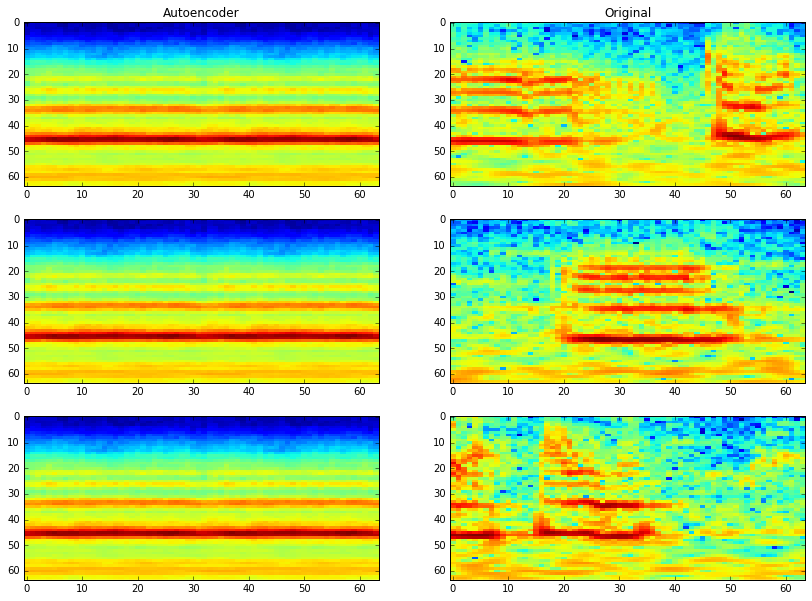

In [46]:
original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape(freq_bins,time_bins)+mean_img.reshape(freq_bins,time_bins),aspect='auto',interpolation='none')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',interpolation='none')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

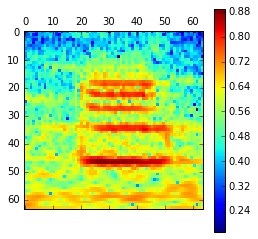

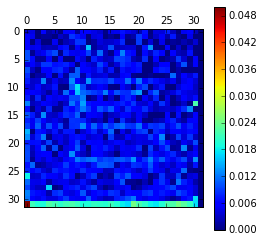

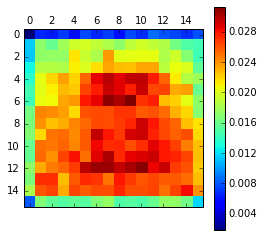

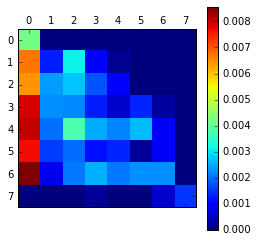

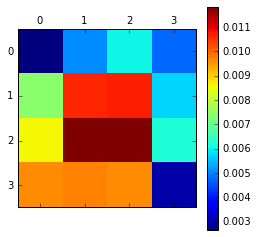

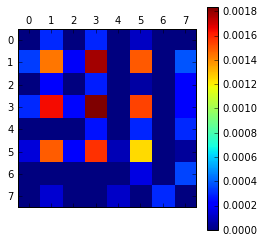

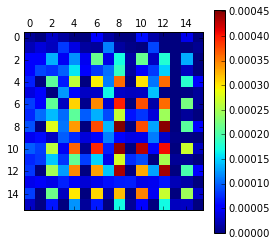

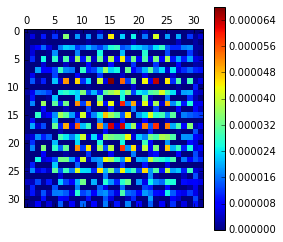

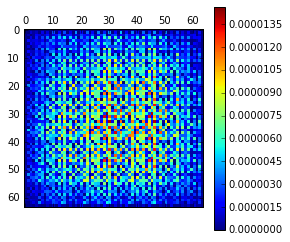

In [49]:
for l_ in l:
    recon = sess.run(l_, feed_dict={ ae['X']: data.data[21:22]-mean_img})
    matshow(recon[0,:,:,0])
    colorbar()

In [20]:
recon.shape

(3, 4096)

In [ ]:
imshow(mean_img.reshape(64,64))